# ANALYSIS SUMMARY:
-------------

For any deep learning problem, it is important to have more and more data. Our analysis, infact shows that this is true. Additionally, other stuffs like Exponential weighted average Batch normalization makes the model more robust.

* First, we implement a simple base line model where we simple get embeddings for each image in the train and cv set. Note, we use the weights from the pretrained inception model from Face Net. The embeddings(features) were trained using a SVM classifier and the cross validation set was tested. The avg validation accuracy for 10 Fold was appx 35%, which is not a very great number.

* Due to bad outcomes from the base line model, we try to finetune the last layer of inception net with 90 images (30 image each label) and without exp weighted batch normalization. The accuracy of the model was very poor, jumping between 10% to 60%.

* Then we added more data 180 images (+30 images each label) the model performed little better than the previous model. But still the outcomes were inconsistent.

* Adding Exponential batch norm , made the results consistent accross runs. But we still had accuracy droping to 10%-20% per batch.

* We added more data 300 images (100 images per label). The results were far batter than the previous run and were also consistent. The results at this point were consistent. Cross validation 1 batch accuracy was between 60 to 70 percent. The problem however was that the accuracy decreased after epoch 6. Early stopping could help.

* After adding learning rate decay, as expected the cross validation accuracy gets more consistent accross different batches and produces a accuracy of 83% at epoch 10.

#### Shrewd finding:
In the code we have many different seeds. The output highly depends on the seed we use, because the triplet selection may find many hard negatives, and selecting one based on seed may be biased.
  * When we run the code from start we see that at batch 10 a lot of images are miscalssified. The common pattern is that they are all similar type of images. For example, sam (I) have two different segment of image, 1) with long hairs, 2) With trimmed hair. When we run the model and observe the misclassification images, we see that all the images misclassified were trimmed hair images.

2. We try different values of triplet_selection_alpha (threshold for negative images to qualify as hard negative). We observe better confidence (probability) outcomes of the prediction when triplet_selection_alpha is greater. For example **pred_prob(alpha=0.7) > pred_prob(alpha=0.5) > pred_prob(alpha=0.3) > pred_prob(alpha=0.1)**. If an image is classified as sam then the ** pred_prob(alpha=0.7) = 0.98, pred_prob(alpha=0.5) = 0.8, pred_prob(alpha=0.3) = 0.7, pred_prob(alpha=0.1) = 0.4**

3. **ACCURACY:**
   * At triplet_selection_alpha=0.09, we saw accuracy of 0.9 consistent accross many epoch, for 1 fold
   * At triplet_selection_alpha=0.07, we saw accuracy of 0.86(avg) consistent accross many epoch, for 1 fold
   * At triplet_selection_alpha=0.2, we saw accuracy decreasing to 0.8 consistency accross many epoch, for 1 fold. When compared to 0.09, the triplet selction alpha value of 0.2 seems to overfit a little bit, hence the confidence of prediction (pred_prob) decreases.
   



#### TO NOTE:

The triplet selection is differnt for every differnt run even after having seed. This could be because small changes in embedding may initiate different triplet seletion. Embedding can be different becasue we have many random preprocessing steps. 

In [1]:
from __future__ import division, print_function, absolute_import

import os
import numpy as np
import tensorflow as tf
import logging
from data_transformer.data_formatter import DataFormatter
from data_transformer.preprocess import Preprocessing

from data_transformer.data_prep import DataIO, genDistinctStratifiedBatches, genRandomStratifiedBatches
from nn.load_params import layer_name, convShape, getWeights
from train_test.model import *
from train_test.classify import SVM
from train_test import analysis
from config import path_dict

import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

logging.basicConfig(level=logging.DEBUG, filename="logfile.log", filemode="w",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")

training = False
verification = False
create_batches = False
base_model_run = False

# ONE TIME RUN: 
------------
#### INPUT :  Folder path with images of several people, ensure the image folders are named with the person name
#### OUTPUT: Dumps a pickle file with three keys, dataX, dataY, labelDict. 
            * dataX: images converted into nd array
            * dataY: for each record of nd array, Labels are numerical (1,2,3,4,5)
            * labelDict: Contains the label corresponding to person name.



In [2]:
if training:
    objDP = DataFormatter(path_dict['parent_path'], 'training')
    objDP.createResizedData()
    dataX, dataY, labelDict, person_name_image_num_info = objDP.imageToArray(get_stats=True)
    
    DataFormatter.dumpPickleFile(dataX, dataY, labelDict,
                                 folderPath=os.path.join(path_dict['data_model_path']),
                                 picklefileName='training_imgarr.pickle')

    DataFormatter.dumpCSVFile(person_name_image_num_info,
                                 folderPath=os.path.join(path_dict['data_model_path']),
                                 csvfileName='person_name_image_num_info.csv')
    
    
if verification:
    objDP = DataFormatter(path_dict['parent_path'], 'verification')
    objDP.createResizedData()
    dataX, dataY, labelDict = objDP.imageToArray()
    DataFormatter.dumpPickleFile(dataX, dataY, labelDict,
                               folderPath=os.path.join(path_dict['data_model_path']),
                               picklefileName='verification_imgarr.pickle')

# CREATE DISTINCT/RANDOM STRATIFIED BATCHES:
----------------
#### INPUT: Image nd array as input  [num_images, imgX, imgY, num_channels]
#### OUTPUT: Outputs a pickle file with shape [num_batches, num_image_per_batch, imgX, imgY, num_channels]

       *  We would wanna do stocastic descent for minibatches and update the parameters perbatch. This module attempts to create stratified batches (each batch would have equal distribution of labels). 
       
       * when genDistinctStratifiedBatches. The images in the batched would be distinct (would not repeat)
       * when genRandomStratifiedBatches. No seed is set for shuffling. So Images in different batches may repeat.

In [3]:
if create_batches:
    trainX, trainY, trainLabelDict = DataIO.getPickleFile(path_dict['data_model_path'],
                                                                 'training_imgarr.pickle')
    verX, verY, verLabelDict = DataIO.getPickleFile(path_dict['data_model_path'],
                                                           'verification_imgarr.pickle')
    print(trainX.shape, trainY.shape)
    print(verX.shape, verY.shape)
    genDistinctStratifiedBatches(trainX, trainY,
                          fileName='distinct_stratified_batches.pickle')

## RESET TENSORFLOW GRAPH

In [ ]:
def reset_graph():  # Reset the graph
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

## GET INCEPTION WEIGHTS

In [ ]:
moduleWeightDict = getWeights(path_dict['inception_nn4small_weights_path'])

# TRAIN AND TEST
---------

TO DO's:

1. Remove the random weight initialiazer for the last layer, and initialize it 
   with the inception net weights and then finetune.  **DONE**

2. implement a module to save weights as checkpoints to the disk.  **DONE**

3. create a function to toggle between Random weight initializer, Inception net weight initializer 
   and using the saved checkpoint for the last Inception layer. **DONE**
   
4. REMEBER TO STORE THE exponential weighted average of mean and variable in the batch normalization 
      fine tune function. SET THESE AS A VARIABLE (LOOK AT CIFAR CODE FOR HELP) **DONE**
 
5. Add more images. **DONE**

6. Create a complete workflow train the network and perform cross validation: **DONE**

7. Store 1 image encodings for the 3-4 labels you have.

8. For a new image, pass the image throught network, get the encoding and see which is the most closest face using the encoding from the step 6.

9. Try :
    1. SVM classfication on embedding feature space: Get cross validation accuracy: **DONE**
    2. Softmax classification on embedding feature space: Get cross validation accuracy. 
    
10. The triplet selection now has, random selection of Hard negative. Having random selection makes it difficult to adjust parameters. So make is generated by a sedd, but the sees itself should be generated randomly via a different sees. Since having the same seeed decide a triplet would be problematic becasue the same hard negative would always be selected. **DONE**

11. Add learning rate decay. **DONE**

12. Softmax classifier

13. Add baseline model, using only pretrained weights: **DONE**

14. Add Statistics, for example images that werent classified. What was the probability of classification. 
    If the image was classified that what is the confidence. **DONE**
    
15. When we run the code again without restarting the jupyter notebook, then we get a complete different output. This could be the result of some values already persisting in the notebook. CHECK if it is due to the seed or some value persisting. (YUP SEED MATTERS, BECAUSE WHEN WE SET SEED BASED ON THE SEED VALUE TAKEN BY 2ND RUN (THAT PRODUCED GOOD OUTPUT, THE INITIAL CV ACCURACY WERE APPX 90%))

# BASELINE MODEL:
---------------

### When using Pretrained weights for all layers
* We see that the training accuracy is pretty high (which would be the case) but the cross validation accuracy every fold is at an average 35% which is very less but better than random guessing. We know that convolutional layer at later stage are able to learn very complex features. The inception net weights were trained on a dataset that is different from the dataset being used here despite both being images of faces. Hence the model would overfit.

* There fore it is suggested to finetune last few layers of the network and relearning the weights fof only last few layers.

In [ ]:
from tensorflow.python.framework import ops
import config
from config import myNet
from copy import deepcopy

which_file = 'distinct_stratified_batches.pickle'
checkpoint_file_name = 'distinct_stratified_model'

class Execute():
    def __init__(self, params, myNet, embeddingType='finetune'):
        self.params = params
        self.embeddingType = embeddingType
        self.myNet = myNet
        self.myNet['learning_rate'] = 0.0001
        
    def runPreprocessor(self, dataIN, sess):
        preprocessedData = np.ndarray(shape=(dataIN.shape), dtype='float32')
        print (preprocessedData.shape, dataIN.shape[0])
        for numImage in np.arange(dataIN.shape[0]):
            feed_dict = {
                self.preprocessGraphDict['imageIN']:dataIN[numImage,:]
            }
            preprocessedData[numImage,:] = sess.run(self.preprocessGraphDict['imageOUT'],
                                                      feed_dict=feed_dict)
        return preprocessedData
        
    def train(self, trnX_, trnY_, sess):
        '''
            1. Preprocess the image and directly get the embedding without finetuning.
            3. Use the embeddings as feature for a classifier (svm/softmax)
            4. Classify faces using the embeddings.
        '''
        trainEmbedGraph = getEmbeddings(self.myNet['image_shape'], self.params)
        embeddings = sess.run(trainEmbedGraph['embeddings'], 
                              feed_dict={trainEmbedGraph['inpTensor']:trnX_})
        logging.info('Training Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        obj_svm.train(embeddings, labels=trnY_, 
                      model_name='baseline_nFold_%s'%(str(self.nFold)))
        train_labels, train_label_prob = obj_svm.classify(embeddings, 
                                model_name='baseline_nFold_%s'%(str(self.nFold)))
        return train_labels, train_label_prob
    
    def cvalid(self, cvX_, sess):
        embedGraph = getEmbeddings(self.myNet['image_shape'], self.params)
        embeddings = sess.run(embedGraph['embeddings'], 
                              feed_dict={embedGraph['inpTensor']:cvX_})
        logging.info('Cross validation Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        cv_labels, cv_label_prob = obj_svm.classify(embeddings, 
                                             model_name='baseline_nFold_%s'%(str(self.nFold)))
        return cv_labels, cv_label_prob
    
    def accuracy(self, y, y_hat):
        return np.mean(np.equal(y_hat, y))

    def run(self):
        # GET THE BATCH DATA FROM THE DISK
        dataX, dataY, labelDict = DataFormatter.getPickleFile(
            folderPath=path_dict['batchFolderPath'], picklefileName=which_file, getStats=True
        )
        trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in  np.arange(len(dataX))]
        cvBatch_idx = [i for i in  np.arange(len(dataX))]
        logging.info('dataX.shape = %s, dataY.shape = %s',str(dataX.shape), str(dataY.shape))
            
        avg_tr_acc = 0
        avg_cv_acc = 0
        # LOOP FOR N-FOLD CROSS VALIDATION
        for nFold, (trn_batch_idx, cv_batch_idx) in enumerate(zip(trnBatch_idx, cvBatch_idx)):
            self.nFold = nFold + 1
            logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
            trnX = dataX[trn_batch_idx,:]
            trnY = dataY[trn_batch_idx,:]
            cvX = dataX[cv_batch_idx,:]
            cvY = dataY[cv_batch_idx,:]
            logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s', 
                  str(trnX.shape), str(trnY.shape), str(cvX.shape), str(cvY.shape))
            
            # Reset graph to do a fresh start for each Fold
            reset_graph()
            self.preprocessGraphDict = Preprocessing().preprocessImageGraph(
                                                                imageShape=self.myNet["image_shape"])
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                # TRAIN, GET TRAINING PREDICTION AND ACCURACY
                trnX_ = trnX.reshape(-1, trnX.shape[2], trnX.shape[3], trnX.shape[4]) # accumulate all batches
                preprocessedData = self.runPreprocessor(dataIN=trnX_, sess=sess)
                logging.info('Preprocessed Data.shape = %s', str(preprocessedData.shape))
                trnY_ = trnY.flatten()
                train_labels, _ = self.train(preprocessedData, trnY_, sess)
                tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
                avg_tr_acc = avg_tr_acc + tr_acc
                print ("Fold: %s, Train acc = %s "%(str(self.nFold) , str(tr_acc)))

                # GET CROSS VALIDATION PREDICTION AND ACCURACY
                cv_labels, _ = self.cvalid(cvX, sess)
                cv_acc = self.accuracy(y=cvY, y_hat=cv_labels)
                avg_cv_acc = avg_cv_acc + cv_acc
                print ("Fold: %s, CV acc = %s "%(str(self.nFold) , str(cv_acc)))
                    
#                     break
        print ("Total %s Folds, Avg Train acc = %s, Avg CV acc = %s "%(str(self.nFold) , 
                                                                       str(round(avg_tr_acc/self.nFold, 3)), 
                                                                       str(round(avg_cv_acc/self.nFold, 3)))
              )
    
    
if base_model_run:
    objExec = Execute(params=deepcopy(moduleWeightDict), myNet=myNet, embeddingType='finetune')
    objExec.run()

# FINE TUNE MODEL:
------------

### When Fine tuning the weights of the last two layers
* When we fine tune only the last inception layer of the new and use the same configured SVM classifier, we see that the cross validation accuracy has increased by more that 25%.


In [ ]:
def vizualize(validacc_dict, trainacc_dict, meanValidAcc, rows, columns, figsize=(40,20), xlabels=None, ylabels=None, titles=None):
    fig1, axs = plt.subplots(rows, columns, figsize=figsize, facecolor='w', edgecolor='k')   # 
#     print (axs)
#     if columns > 1:
    axs = axs.ravel()
    numFolds = len(validacc_dict.keys())
    for foldNum in np.arange(numFolds):
#         print (foldNum)
        axs[foldNum].plot(validacc_dict[foldNum+1])
        axs[foldNum].plot(trainacc_dict[foldNum+1])
        axs[foldNum].axhline(y=meanValidAcc, color = 'k')
        axs[foldNum].set_title('Validation/Training accuracy Fold:%s '%str(foldNum+1))
        axs[foldNum].legend(['validation acc', 'training acc', ['n-fold avg valid acc']], loc=4)

In [ ]:
from tensorflow.python.framework import ops
import config
from config import myNet
from train_test.analysis import save_prediction_analysis
from copy import deepcopy

which_file = 'distinct_stratified_batches.pickle'
checkpoint_file_name = 'distinct_stratified_model'

'''
dataX = [num_batches, image_per_batch, image_x, image_y, image_channels]
dataY = [num_batches, labels]

'''


class Execute():
    def __init__(self, myNet, embeddingType='finetune', hyper_params={}):
        self.myNet = myNet
        self.embeddingType = embeddingType
        
#         print (hyper_params)
        if 'learning_rate_override' in  hyper_params.keys():
            self.myNet['learning_rate'] = hyper_params['learning_rate_override']
        
        self.save_for_analysis = hyper_params['save_for_analysis']
        self.use_checkpoint = hyper_params['use_checkpoint']
        self.how_many_folds = hyper_params['how_many_folds']
        self.numEpochs = hyper_params['numEpochs']
        self.which_eopch_to_save = hyper_params['which_eopch_to_save']
    
    def runPreprocessor(self, dataIN, sess):
        preprocessedData = np.ndarray(shape=(dataIN.shape), dtype='float32')
        for numImage in np.arange(dataIN.shape[0]):
            feed_dict = {
                self.preprocessGraphDict['imageIN']: dataIN[numImage, :]
            }
            preprocessedData[numImage, :] = sess.run(self.preprocessGraphDict['imageOUT'],
                                                     feed_dict=feed_dict)
        return preprocessedData
    
    def resetWeights(self, weightsIN):
        logging.info('RESETTING WEITHGS WITH PRE-TRAINED WEIGHTS .........')
        self.weights = weightsIN
    
    def setNewWeights(self, sess):
        logging.info('UPDATING WEITHGS WITH FINETUNED WEIGHTS .........')
        #         trainableVars = tf.get_collection(ops.GraphKeys.TRAINABLE_VARIABLES)
        if self.embeddingType == 'finetune':
            for learned_vars in config.finetune_variables:
                scope, name = learned_vars.split(':')[0].split('/')
                if len(self.weights[scope][name]) != 0:
                    var_ = sess.run(learned_vars)
                    logging.info('Updating param with scope %s and name %s and shape %s with shape %s',
                                 str(scope), str(name), str(self.weights[scope][name].shape), str(var_.shape))
                    self.weights[scope][name] = var_
                else:
                    raise ValueError('It seems that the scope %s or variable %s didnt exist in the dictionary ' % (
                        str(scope), str(name)))
    
    def train(self, trnX_, trnY_, sess):
        '''
            1. Make the use of getEmbedding to get the graph with last layer parameter updated with the 
            fine tuned weights.
            2. Get the new embedding for batch/epoch using the computation graph
            3. Use the embeddings as feature for a classifier (svm/softmax)
            4. Classify faces using the new embeddings.
        '''
        trainEmbedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        embeddings = sess.run(trainEmbedGraph['embeddings'],
                              feed_dict={trainEmbedGraph['inpTensor']: trnX_})
        logging.info('Training Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        obj_svm.train(embeddings, labels=trnY_,
                      model_name='nFold_%s_batch_%s' % (str(self.nFold), str(self.epoch)))
        train_labels, train_label_prob = obj_svm.classify(embeddings,
                                                          model_name='nFold_%s_batch_%s' % (
                                                              str(self.nFold), str(self.epoch)))
        return train_labels, train_label_prob
    
    def cvalid(self, cvX_, sess):
        embedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
        embeddings = sess.run(embedGraph['embeddings'],
                              feed_dict={embedGraph['inpTensor']: cvX_})
        logging.info('Cross validation Embeddings shape %s', embeddings.shape)
        obj_svm = SVM()
        cv_labels, cv_label_prob = obj_svm.classify(embeddings,
                                                    model_name='nFold_%s_batch_%s' % (str(self.nFold), str(self.epoch)))
        return cv_labels, cv_label_prob
    
    def accuracy(self, y, y_hat):
        return np.mean(np.equal(y_hat, y))
    
    #     def test(self, tstGraph, testBatch, sess):
    #         # METHOD 2: TO get weights is form of Tensors
    #         a = saver.restore(sess, os.path.join(checkpoint_path, "model.ckpt"))
    #         trainableVars = tf.get_collection(ops.GraphKeys.TRAINABLE_VARIABLES)
    #         testDict = getFineTunedEmbeddings([96,96,3], moduleWeightDict, trainableVars, sess)
    #         embeddings = sess.run([tstGraph['output']], feed_dict={'inpTensor':testBatch})
    #         return embeddings
        
    
    def sess_exec(self, trnX, trnY, cvX, cvY):
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            # Save the checkpoint of the run 
            checkpoints = [ck for ck in os.listdir(path_dict['checkpoint_path']) if ck != '.DS_Store']
            if len(checkpoints) > 0 and self.use_checkpoint:
                saver.restore(sess, os.path.join(path_dict['checkpoint_path'],
                                                 "distinct_stratified_model.ckpt"))
            
            # Get the summary output for tensorboard
            self.mergedSummary, self.writer = summaryBuilder(sess, path_dict["summary_path"])
            
            tr_acc_arr = []
            cv_acc_arr = []
            for epoch in np.arange(self.numEpochs):
                self.epoch = epoch + 1
                logging.info('RUNNING : %s EPOCH ........................', str(self.epoch))
                # Below loop will minimize the triplet loss and update the parameters
                for batchNum, batchX in enumerate(trnX[0:len(trnX), :]):
                    logging.info('RUNNING BATCH %s for shape = %s', str(batchNum + 1), str(batchX.shape))
                    
                    # Step1 : Preprocess the Data
                    preprocessedData = self.runPreprocessor(dataIN=batchX, sess=sess)
                    
                    # Since we improve on our previous prediction, there can be cases where the network has learned a
                    #  good enough
                    # decision boundary (for a batch) and is unable to find hard negative for the triplet selection. 
                    # In such a case
                    # the network would return an empty array, which would raise a run time exception during the 
                    # graph is computed.
                    # For such cases we would except an exception, and let the graph proceed. 
                    
                    try:
                        feed_dict = {self.trn_embed_graph['inpTensor']: preprocessedData}
                        opt, batch_loss, lr = sess.run([self.trn_embed_graph['optimizer'],
                                                        self.trn_embed_graph['triplet_loss'],
                                                        self.trn_embed_graph['learning_rate']],
                                                       feed_dict=feed_dict)
                    except Exception:
                        logging.info(
                                'Exception Raised! Check the log file and confirm if the exception is becasue of empty '
                                'triplet array. If not then debugg it :)')
                        logging.info("Fold = %s, Epoch = %s, Loss = %s",
                                     str(self.nFold), str(self.epoch), "{:.6f}".format(batch_loss))
                
                # Store the summary, and print the loss, accuracy after every epoch or for every batch
                smry = sess.run(self.mergedSummary, feed_dict = feed_dict)
                self.writer.add_summary(smry, self.epoch)
                
                print("Fold= " + str(self.nFold) +
                      ", Epoch= " + str(self.epoch) +
                      ", Loss= " + "{:.6f}".format(batch_loss))
                
                if self.use_checkpoint:
                    save_path = saver.save(sess,os.path.join(path_dict['checkpoint_path'], 
                                                             "distinct_stratified_model.ckpt"))
                
                # Now that we have updated our parameters (weights and biases), we would
                # fetch the embeddings using the updated parameter and train-test model
                # to get an accuracy. Accuracy per epoch is now a good way to go
                self.setNewWeights(sess)  # replace the last layer's inception weights with leared finetuned weights
                
                # TRAIN, GET TRAINING PREDICTION AND ACCURACY
                trnX_ = trnX.reshape(-1, trnX.shape[2], trnX.shape[3], trnX.shape[4])  # accumulate all batches
                trnY_ = trnY.flatten()
                train_labels, _ = self.train(trnX_, trnY_, sess)
                tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
                tr_acc_arr.append(tr_acc)
                print("Fold: %s, Train acc = %s " % (str(self.nFold), str(tr_acc)))
                
                
                # GET CROSS VALIDATION PREDICTION AND ACCURACY
                cv_labels, cv_pred_prob = self.cvalid(cvX, sess)
                cv_acc = self.accuracy(y=cvY, y_hat=cv_labels)
                cv_acc_arr.append(cv_acc)
                print("Fold: %s, CV acc = %s " % (str(self.nFold), str(cv_acc)))
        
                if self.epoch in self.which_eopch_to_save and self.save_for_analysis:
                    save_prediction_analysis(cv_act=cvY, cv_hat=cv_labels, cv_hat_prob=cv_pred_prob, 
                                             fold=self.nFold, epoch=self.epoch, cvBatch_num = self.cv_batch_idx)
            self.writer = tf.summary.FileWriter(path_dict["summary_path"], sess.graph)
            self.writer.close()
        return tr_acc, cv_acc, tr_acc_arr, cv_acc_arr
    
    def run(self, weightsIN):
        self.weights = weightsIN
        # GET THE BATCH DATA FROM THE DISK
        dataX, dataY, labelDict = DataFormatter.getPickleFile(
                folderPath=path_dict['batchFolderPath'], picklefileName=which_file, getStats=True
        )
        trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in np.arange(len(dataX))]
        cvBatch_idx = [i for i in np.arange(len(dataX))]
        
        logging.info('dataX.shape = %s, dataY.shape = %s', str(dataX.shape), str(dataY.shape))
        
        # NOTE WE HAVE TO RESET THE WEIGHTS to the Inception weights every FOLD
        tr_acc_dict = {}
        cv_acc_dict = {}
        tr_acc_avg = 0
        cv_acc_avg = 0
        for nFold, (trn_batch_idx, cv_batch_idx) in enumerate(zip(trnBatch_idx, cvBatch_idx)):
            
            self.nFold = nFold + 1
            self.cv_batch_idx = cv_batch_idx + 1
            print('Training Batch Numbers ', [bb+1 for bb in trn_batch_idx]) 
            print('CV Batch Number ', self.cv_batch_idx) 
            
            logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
            trnX = dataX[trn_batch_idx, :]
            trnY = dataY[trn_batch_idx, :]
            cvX = dataX[cv_batch_idx, :]
            cvY = dataY[cv_batch_idx, :]
            logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s',
                         str(trnX.shape), str(trnY.shape), str(cvX.shape), str(cvY.shape))
            
            
            # RESET AND CREATE THE GRAPH
            reset_graph()
            self.trn_embed_graph = trainEmbeddings(self.weights, init_wght_type='random')
            self.preprocessGraphDict = Preprocessing().preprocessImageGraph(imageShape=self.myNet["image_shape"])
            # EXECUTE THE SESSION FOR THE CURRENT FOLD
            tr_acc, cv_acc, tr_acc_arr, cv_acc_arr = self.sess_exec(trnX, trnY, cvX, cvY)
            self.resetWeights(weightsIN)
            
            ######## add ops to save and restore model
            ########
            ######## add ops to save and restore model    
            
            ###  GET FINAL ACURACY
            tr_acc_avg += tr_acc
            cv_acc_avg += cv_acc
            tr_acc_dict[self.nFold] = tr_acc_arr
            cv_acc_dict[self.nFold] = cv_acc_arr
            print('')
            
            if self.nFold == self.how_many_folds:
                break
            
        cv_acc_avg = round(cv_acc_avg / self.nFold, 3)
        tr_acc_avg = round(tr_acc_avg / self.nFold, 3)
        print("Total %s Folds, Avg Train acc = %s, Avg CV acc = %s " % (str(self.nFold),
                                                                        str(tr_acc_avg),
                                                                        str(cv_acc_avg))
              )
        return tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict

# 10 FOLD RUN
----------------

### triplet_selection_alpha = 0.09, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.465466
Fold: 1, Train acc = 0.818518518519 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 19.508535
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.087723
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 15.677329
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 5, Loss= 13.216620
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 6, Loss= 8.815880
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.303071
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 3.753622
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 9, Loss= 2.028427
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 2.033058
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 

Training

Fold: 8, Train acc = 0.644444444444 
Fold: 8, CV acc = 0.633333333333 
Fold= 8, Epoch= 8, Loss= 10.584438
Fold: 8, Train acc = 0.781481481481 
Fold: 8, CV acc = 0.766666666667 
Fold= 8, Epoch= 9, Loss= 6.289798
Fold: 8, Train acc = 0.792592592593 
Fold: 8, CV acc = 0.866666666667 
Fold= 8, Epoch= 10, Loss= 0.402609
Fold: 8, Train acc = 0.814814814815 
Fold: 8, CV acc = 0.833333333333 

Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 10]
CV Batch Number  9
Fold= 9, Epoch= 1, Loss= 24.062130
Fold: 9, Train acc = 0.762962962963 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 2, Loss= 19.768885
Fold: 9, Train acc = 0.666666666667 
Fold: 9, CV acc = 0.666666666667 
Fold= 9, Epoch= 3, Loss= 18.416840
Fold: 9, Train acc = 0.792592592593 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 4, Loss= 19.005978
Fold: 9, Train acc = 0.792592592593 
Fold: 9, CV acc = 0.833333333333 
Fold= 9, Epoch= 5, Loss= 18.314392
Fold: 9, Train acc = 0.840740740741 
Fold: 9, CV acc = 0.766666666667 
Fold= 9, Epoch= 6, L

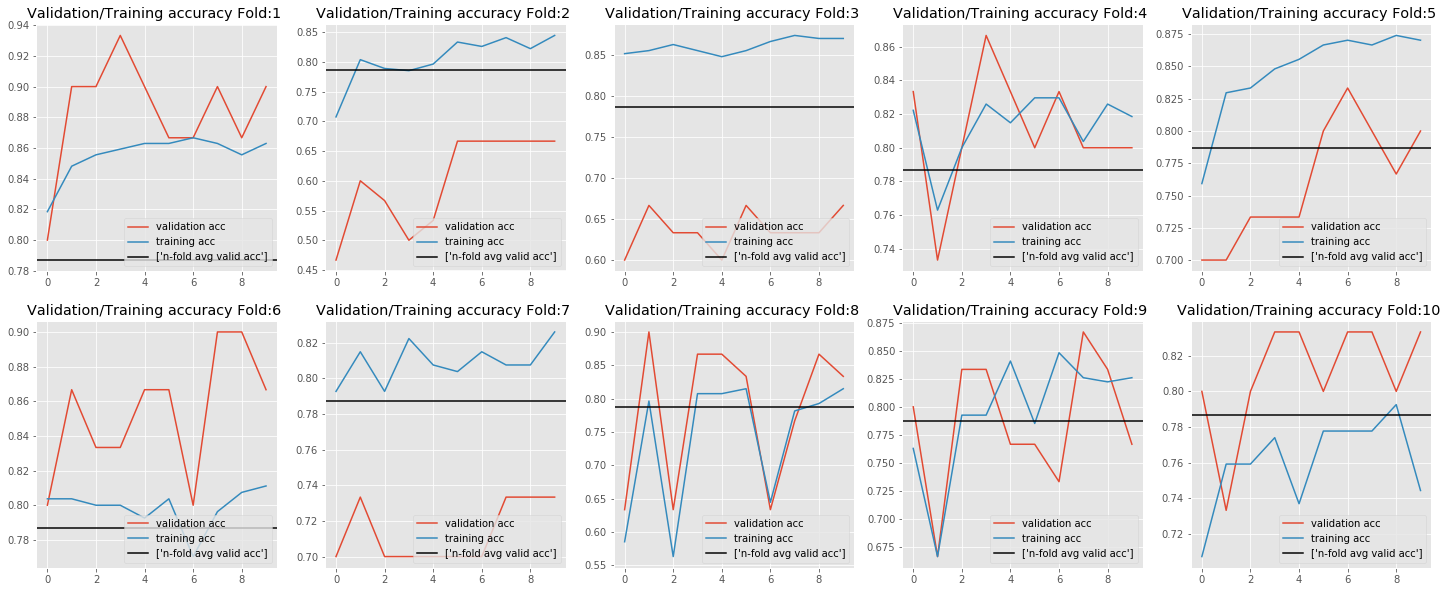

In [16]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.07, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 23.262985
Fold: 1, Train acc = 0.82962962963 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 18.825903
Fold: 1, Train acc = 0.844444444444 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.497753
Fold: 1, Train acc = 0.837037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 4, Loss= 16.749117
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 5, Loss= 14.382219
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 6, Loss= 9.779840
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 7, Loss= 9.818924
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 4.872028
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 2.510174
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 1.995747
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV a

Fold= 8, Epoch= 8, Loss= 10.485617
Fold: 8, Train acc = 0.814814814815 
Fold: 8, CV acc = 0.866666666667 
Fold= 8, Epoch= 9, Loss= 6.439397
Fold: 8, Train acc = 0.774074074074 
Fold: 8, CV acc = 0.833333333333 
Fold= 8, Epoch= 10, Loss= 1.356001
Fold: 8, Train acc = 0.822222222222 
Fold: 8, CV acc = 0.866666666667 

Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 10]
CV Batch Number  9
Fold= 9, Epoch= 1, Loss= 24.495924
Fold: 9, Train acc = 0.614814814815 
Fold: 9, CV acc = 0.566666666667 
Fold= 9, Epoch= 2, Loss= 20.849289
Fold: 9, Train acc = 0.811111111111 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 3, Loss= 18.914375
Fold: 9, Train acc = 0.711111111111 
Fold: 9, CV acc = 0.733333333333 
Fold= 9, Epoch= 4, Loss= 20.278236
Fold: 9, Train acc = 0.8 
Fold: 9, CV acc = 0.766666666667 
Fold= 9, Epoch= 5, Loss= 17.528454
Fold: 9, Train acc = 0.785185185185 
Fold: 9, CV acc = 0.766666666667 
Fold= 9, Epoch= 6, Loss= 14.502321
Fold: 9, Train acc = 0.840740740741 
Fold: 9, CV acc = 0.8 
Fold= 9

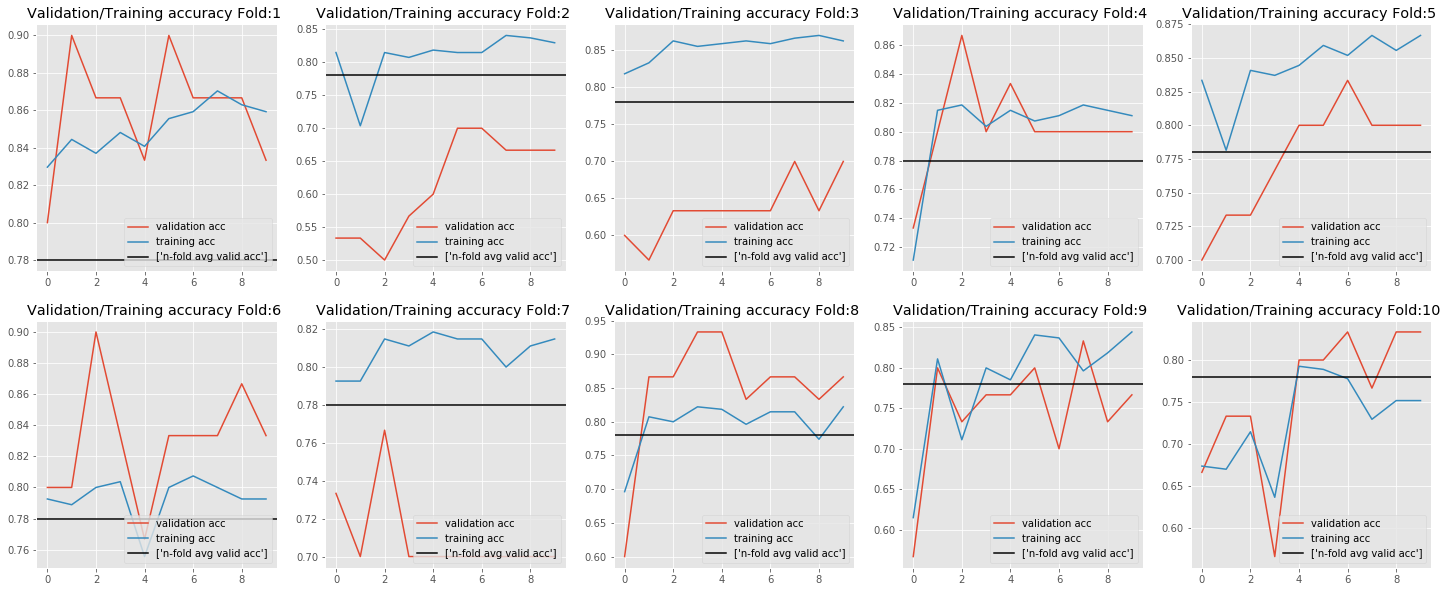

In [10]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.05, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.709976
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 2, Loss= 19.219387
Fold: 1, Train acc = 0.825925925926 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.761038
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 16.246586
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 5, Loss= 15.570947
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 6, Loss= 10.135323
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.656178
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 5.991520
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 3.292241
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 3.520585
Fold: 1, Train acc = 0.862962962963 
Fold: 1, C

Fold: 8, CV acc = 0.833333333333 
Fold= 8, Epoch= 7, Loss= 14.225761
Fold: 8, Train acc = 0.818518518519 
Fold: 8, CV acc = 0.866666666667 
Fold= 8, Epoch= 8, Loss= 10.771105
Fold: 8, Train acc = 0.8 
Fold: 8, CV acc = 0.8 
Fold= 8, Epoch= 9, Loss= 7.270331
Fold: 8, Train acc = 0.788888888889 
Fold: 8, CV acc = 0.866666666667 
Fold= 8, Epoch= 10, Loss= 2.324545
Fold: 8, Train acc = 0.807407407407 
Fold: 8, CV acc = 0.9 

Training Batch Numbers  [1, 2, 3, 4, 5, 6, 7, 8, 10]
CV Batch Number  9
Fold= 9, Epoch= 1, Loss= 25.706573
Fold: 9, Train acc = 0.803703703704 
Fold: 9, CV acc = 0.766666666667 
Fold= 9, Epoch= 2, Loss= 20.452532
Fold: 9, Train acc = 0.814814814815 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 3, Loss= 19.126007
Fold: 9, Train acc = 0.707407407407 
Fold: 9, CV acc = 0.733333333333 
Fold= 9, Epoch= 4, Loss= 19.733793
Fold: 9, Train acc = 0.785185185185 
Fold: 9, CV acc = 0.8 
Fold= 9, Epoch= 5, Loss= 18.144827
Fold: 9, Train acc = 0.788888888889 
Fold: 9, CV acc = 0.8 
Fold= 

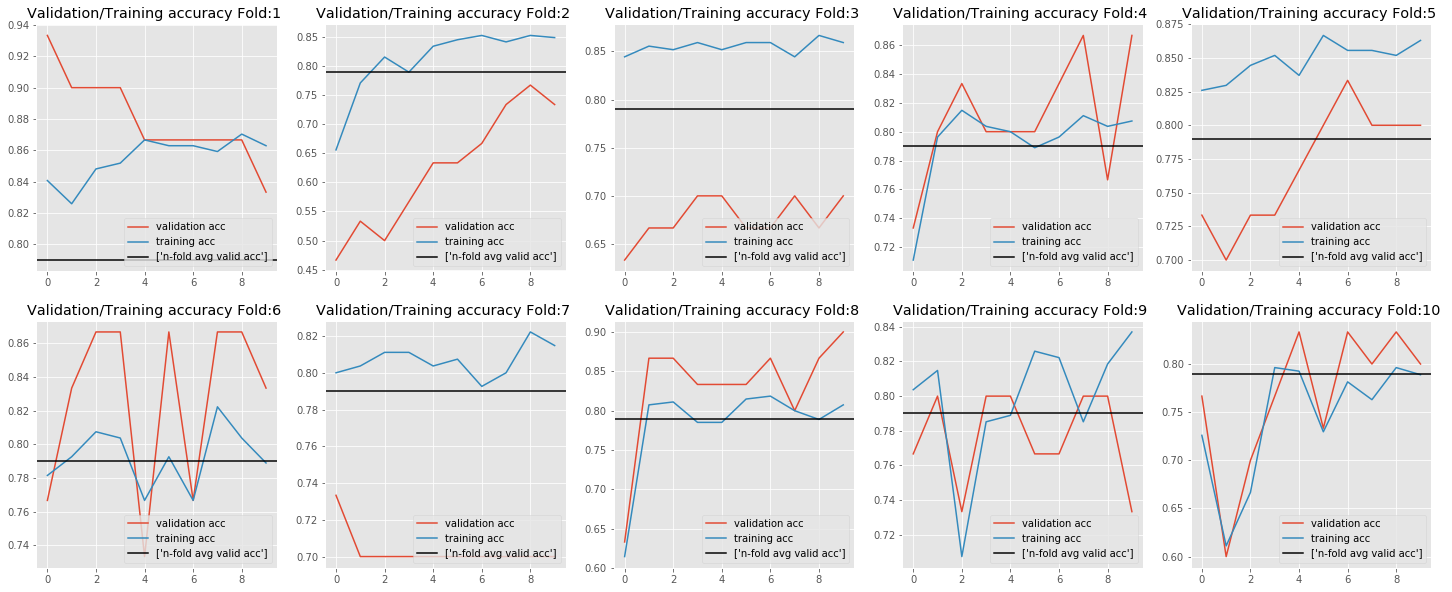

In [10]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.03, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [ ]:
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 10,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

In [ ]:
rows = 2
columns = 5
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

# 1 FOLD RUN
-----------

### triplet_selection_alpha = 0.1, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
# When 
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 21.956341
Fold: 1, Train acc = 0.844444444444 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 2, Loss= 18.601765
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 3, Loss= 18.104637
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 4, Loss= 15.094838
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 5, Loss= 12.437945
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 6, Loss= 8.238983
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 7, Loss= 9.622285
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 8, Loss= 4.144698
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 9, Loss= 2.133195
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 10, Loss= 2.457368
Fold: 1, Train acc = 0.859259259259 


0


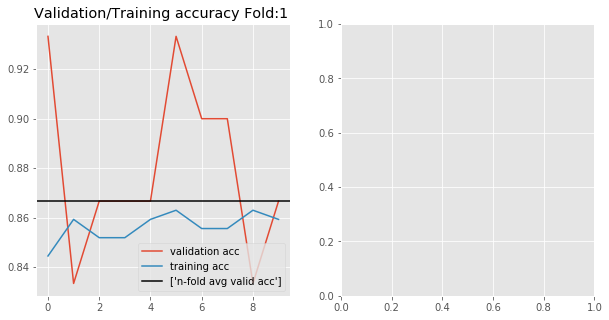

In [10]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.09, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [9]:
# When 
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.465466
Fold: 1, Train acc = 0.818518518519 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 19.508535
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.087723
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 15.677329
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 5, Loss= 13.216620
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 6, Loss= 8.815880
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.303071
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 3.753622
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 9, Loss= 2.028427
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 2.033058
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.9 

Total 1 

0


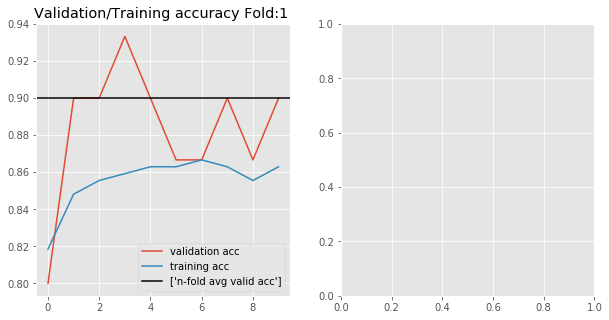

In [10]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.07, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [7]:
# When 'triplet_selection_alpha' = 0.05 and 'triplet_loss_penalty' = 0.2
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 22.709976
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.933333333333 
Fold= 1, Epoch= 2, Loss= 19.219387
Fold: 1, Train acc = 0.825925925926 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.761038
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 4, Loss= 16.246586
Fold: 1, Train acc = 0.851851851852 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 5, Loss= 15.570947
Fold: 1, Train acc = 0.866666666667 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 6, Loss= 10.135323
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 7, Loss= 10.656178
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 5.991520
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 3.292241
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 3.520585
Fold: 1, Train acc = 0.862962962963 
Fold: 1, C

In [ ]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

### triplet_selection_alpha = 0.05, triplet_loss_penalty = 0.2 and learning_rate = 0.0001 (exponential decay)

In [7]:
# When 'triplet_selection_alpha' = 0.07 and 'triplet_loss_penalty' = 0.2
hyper_params =  dict(learning_rate_override = 0.0001,
                     use_checkpoint = False,
                     save_for_analysis = True,
                     how_many_folds = 1,
                     numEpochs = 10,
                     which_eopch_to_save = [5,8,9,10])

objExec = Execute(myNet=myNet, embeddingType='finetune', hyper_params=hyper_params)
tr_acc_avg, cv_acc_avg, tr_acc_dict, cv_acc_dict = objExec.run(weightsIN=deepcopy(moduleWeightDict))

The shape of input data (X) is:  (10, 30, 96, 96, 3)
The shape of input data (Y) is:  (10, 30)
Unique labels in dataY is:  [ 0.  1.  2.]
Label dict:  None
Training Batch Numbers  [2, 3, 4, 5, 6, 7, 8, 9, 10]
CV Batch Number  1


/Users/sam/App-Setup/anaconda/envs/anaconda35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fold= 1, Epoch= 1, Loss= 23.262985
Fold: 1, Train acc = 0.82962962963 
Fold: 1, CV acc = 0.8 
Fold= 1, Epoch= 2, Loss= 18.825903
Fold: 1, Train acc = 0.844444444444 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 3, Loss= 18.497753
Fold: 1, Train acc = 0.837037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 4, Loss= 16.749117
Fold: 1, Train acc = 0.848148148148 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 5, Loss= 14.382219
Fold: 1, Train acc = 0.840740740741 
Fold: 1, CV acc = 0.833333333333 
Fold= 1, Epoch= 6, Loss= 9.779840
Fold: 1, Train acc = 0.855555555556 
Fold: 1, CV acc = 0.9 
Fold= 1, Epoch= 7, Loss= 9.818924
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 8, Loss= 4.872028
Fold: 1, Train acc = 0.87037037037 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 9, Loss= 2.510174
Fold: 1, Train acc = 0.862962962963 
Fold: 1, CV acc = 0.866666666667 
Fold= 1, Epoch= 10, Loss= 1.995747
Fold: 1, Train acc = 0.859259259259 
Fold: 1, CV a

In [ ]:
rows = 1
columns = 2
vizualize(cv_acc_dict, tr_acc_dict, meanValidAcc=cv_acc_avg, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

In [8]:
# from tensorflow.python.framework import ops
# import config
# from config import myNet

# which_file = 'distinct_stratified_batches.pickle'
# checkpoint_file_name = 'distinct_stratified_model'

# '''
# dataX = [num_batches, image_per_batch, image_x, image_y, image_channels]
# dataY = [num_batches, labels]

# '''


# class Execute():
#     def __init__(self, myNet, embeddingType='finetune'):
#         self.embeddingType = embeddingType
#         self.myNet = myNet
#         self.myNet['learning_rate'] = 0.0001
    
#     def runPreprocessor(self, dataIN, sess):
#         preprocessedData = np.ndarray(shape=(dataIN.shape), dtype='float32')
#         for numImage in np.arange(dataIN.shape[0]):
#             feed_dict = {
#                 self.preprocessGraphDict['imageIN']: dataIN[numImage, :]
#             }
#             preprocessedData[numImage, :] = sess.run(self.preprocessGraphDict['imageOUT'],
#                                                      feed_dict=feed_dict)
#         return preprocessedData
    
#     def resetWeights(self, weightsIN):
#         logging.info('RESETTING WEITHGS WITH PRE-TRAINED WEIGHTS .........')
#         self.weights = weightsIN
    
#     def setNewWeights(self, sess):
#         logging.info('UPDATING WEITHGS WITH FINETUNED WEIGHTS .........')
#         #         trainableVars = tf.get_collection(ops.GraphKeys.TRAINABLE_VARIABLES)
#         if self.embeddingType == 'finetune':
#             for learned_vars in config.finetune_variables:
#                 scope, name = learned_vars.split(':')[0].split('/')
#                 if len(self.weights[scope][name]) != 0:
#                     var_ = sess.run(learned_vars)
#                     logging.info('Updating param with scope %s and name %s and shape %s with shape %s',
#                                  str(scope), str(name), str(self.weights[scope][name].shape), str(var_.shape))
#                     self.weights[scope][name] = var_
#                 else:
#                     raise ValueError('It seems that the scope %s or variable %s didnt exist in the dictionary ' % (
#                         str(scope), str(name)))
    
#     def train(self, trnX_, trnY_, sess):
#         '''
#             1. Make the use of getEmbedding to get the graph with last layer parameter updated with the 
#             fine tuned weights.
#             2. Get the new embedding for batch/epoch using the computation graph
#             3. Use the embeddings as feature for a classifier (svm/softmax)
#             4. Classify faces using the new embeddings.
#         '''
#         trainEmbedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
#         embeddings = sess.run(trainEmbedGraph['output'],
#                               feed_dict={trainEmbedGraph['inpTensor']: trnX_})
#         logging.info('Training Embeddings shape %s', embeddings.shape)
#         obj_svm = SVM()
#         obj_svm.train(embeddings, labels=trnY_,
#                       model_name='nFold_%s_batch_%s' % (str(self.nFold), str(self.epoch)))
#         train_labels, train_label_prob = obj_svm.classify(embeddings,
#                                                           model_name='nFold_%s_batch_%s' % (
#                                                               str(self.nFold), str(self.epoch)))
#         return train_labels, train_label_prob
    
#     def cvalid(self, cvX_, sess):
#         embedGraph = getEmbeddings(self.myNet['image_shape'], self.weights)
#         embeddings = sess.run(embedGraph['output'],
#                               feed_dict={embedGraph['inpTensor']: cvX_})
#         logging.info('Cross validation Embeddings shape %s', embeddings.shape)
#         obj_svm = SVM()
#         cv_labels, cv_label_prob = obj_svm.classify(embeddings,
#                                                     model_name='nFold_%s_batch_%s' % (str(self.nFold), str(self.epoch)))
#         return cv_labels, cv_label_prob
    
#     def accuracy(self, y, y_hat):
#         return np.mean(np.equal(y_hat, y))
    
#     #     def test(self, tstGraph, testBatch, sess):
#     #         # METHOD 2: TO get weights is form of Tensors
#     #         a = saver.restore(sess, os.path.join(checkpoint_path, "model.ckpt"))
#     #         trainableVars = tf.get_collection(ops.GraphKeys.TRAINABLE_VARIABLES)
#     #         testDict = getFineTunedEmbeddings([96,96,3], moduleWeightDict, trainableVars, sess)
#     #         embeddings = sess.run([tstGraph['output']], feed_dict={'inpTensor':testBatch})
#     #         return embeddings
    
#     def sess_exec(self, trnX, trnY, cvX, cvY):
#         saver = tf.train.Saver()
        
#         with tf.Session() as sess:
#             sess.run(tf.global_variables_initializer())
            
#             # Save the checkpoint of the run 
#             checkpoints = [ck for ck in os.listdir(path_dict['checkpoint_path']) if ck != '.DS_Store']
#             if len(checkpoints) > 0 and self.myNet['use_checkpoint']:
#                 saver.restore(sess, os.path.join(path_dict['checkpoint_path'],
#                                                  "distinct_stratified_model.ckpt"))
            
#             # Get the summary output for tensorboard
#             self.mergedSummary, self.writer = summaryBuilder(sess, path_dict["summary_path"])
            
#             for epoch in np.arange(numEpochs):
#                 self.epoch = epoch + 1
#                 logging.info('RUNNING : %s EPOCH ........................', str(self.epoch))
#                 # Below loop will minimize the triplet loss and update the parameters
#                 for batchNum, batchX in enumerate(trnX[0:len(trnX), :]):
#                     logging.info('RUNNING BATCH %s for shape = %s', str(batchNum + 1), str(batchX.shape))
                    
#                     # Step1 : Preprocess the Data
#                     preprocessedData = self.runPreprocessor(dataIN=batchX, sess=sess)
                    
#                     # Since we improve on our previous prediction, there can be cases where the network has learned a
#                     #  good enough
#                     # decision boundary (for a batch) and is unable to find hard negative for the triplet selection. 
#                     # In such a case
#                     # the network would return an empty array, which would raise a run time exception during the 
#                     # graph is computed.
#                     # For such cases we would except an exception, and let the graph proceed. 
#                     try:
#                         opt, batch_loss, lr = sess.run([self.trn_embed_graph['optimizer'],
#                                                         self.trn_embed_graph['loss'],
#                                                         self.trn_embed_graph['learning_rate']],
#                                                        feed_dict={self.trn_embed_graph['inpTensor']: preprocessedData})
#                     except Exception:
#                         logging.info(
#                                 'Exception Raised! Check the log file and confirm if the exception is becasue of empty '
#                                 'triplet array. If not then debugg it :)')
#                         logging.info("Fold = %s, Epoch = %s, Loss = %s",
#                                      str(self.nFold), str(self.epoch), "{:.6f}".format(batch_loss))
                
#                 # Store the summary, and print the loss, accuracy after every epoch
#                 smry = sess.run(self.mergedSummary, feed_dict = feed_dict)
#                 self.writer.add_summary(smry, self.step)
                
#                 print("Fold: " + str(self.nFold) +
#                       ", Epoch= " + str(self.epoch) +
#                       ", Loss= " + "{:.6f}".format(batch_loss))
                
#                 save_path = saver.save(sess,os.path.join(path_dict['checkpoint_path'], 
#                                                          "distinct_stratified_model.ckpt"))
                
#                 # Now that we have updated our parameters (weights and biases), we would
#                 # fetch the embeddings using the updated parameter and train-test model
#                 # to get an accuracy. Accuracy per epoch is now a good way to go
#                 self.setNewWeights(sess)  # replace the last layer's inception weights with leared finetuned weights
                
#                 # TRAIN, GET TRAINING PREDICTION AND ACCURACY
#                 trnX_ = trnX.reshape(-1, trnX.shape[2], trnX.shape[3], trnX.shape[4])  # accumulate all batches
#                 trnY_ = trnY.flatten()
#                 train_labels, _ = self.train(trnX_, trnY_, sess)
#                 tr_acc = self.accuracy(y=trnY_, y_hat=train_labels)
#                 print("Fold: %s, Train acc = %s " % (str(self.nFold), str(tr_acc)))
                
#                 # GET CROSS VALIDATION PREDICTION AND ACCURACY
#                 cv_labels, _ = self.cvalid(cvX, sess)
#                 cv_acc = self.accuracy(y=cvY, y_hat=cv_labels)
#                 print("Fold: %s, CV acc = %s " % (str(self.nFold), str(cv_acc)))
        
#             self.writer = tf.summary.FileWriter(path_dict["summary_path"], sess.graph)
#             self.writer.close()
#         return tr_acc, cv_acc
    
#     def run(self, weightsIN, how_many_folds):
#         self.weights = weightsIN
#         # GET THE BATCH DATA FROM THE DISK
#         dataX, dataY, labelDict = DataFormatter.getPickleFile(
#                 folderPath=path_dict['batchFolderPath'], picklefileName=which_file, getStats=True
#         )
#         trnBatch_idx = [list(np.setdiff1d(np.arange(len(dataX)), np.array(i))) for i in np.arange(len(dataX))]
#         cvBatch_idx = [i for i in np.arange(len(dataX))]
#         logging.info('dataX.shape = %s, dataY.shape = %s', str(dataX.shape), str(dataY.shape))
        
#         # LOOP FOR N-FOLD CROSS VALIDATION
#         avg_tr_acc = 0
#         avg_cv_acc = 0
#         # NOTE WE HAVE TO RESET THE WEIGHTS to the Inception weights every FOLD
#         for nFold, (trn_batch_idx, cv_batch_idx) in enumerate(zip(trnBatch_idx, cvBatch_idx)):
#             self.nFold = nFold + 1
#             logging.info('RUNNING : %s FOLD ...........................', str(self.nFold))
#             trnX = dataX[trn_batch_idx, :]
#             trnY = dataY[trn_batch_idx, :]
#             cvX = dataX[cv_batch_idx, :]
#             cvY = dataY[cv_batch_idx, :]
#             logging.info('trnX.shape = %s, trnY.shape = %s, cvX.shape = %s, cvY.shape = %s',
#                          str(trnX.shape), str(trnY.shape), str(cvX.shape), str(cvY.shape))
            
            
#             # RESET AND CREATE THE GRAPH
#             reset_graph()
#             self.trn_embed_graph = trainEmbeddings(self.weights, init_wght_type='random')
#             self.preprocessGraphDict = Preprocessing().preprocessImageGraph(
#                 imageShape=self.myNet["image_shape"])
#             # EXECUTE THE SESSION FOR THE CURRENT FOLD
#             tr_acc, cv_acc = self.sess_exec(trnX, trnY, cvX, cvY)
#             self.resetWeights(weightsIN)
            
#             avg_tr_acc = avg_tr_acc + tr_acc
#             avg_cv_acc = avg_cv_acc + cv_acc
#             # add ops to save and restore model
#             print('')
            
#             if self.nFold == how_many_folds:
#                 break
            
#         print("Total %s Folds, Avg Train acc = %s, Avg CV acc = %s " % (str(self.nFold),
#                                                                         str(round(avg_tr_acc / self.nFold, 3)),
#                                                                         str(round(avg_cv_acc / self.nFold, 3)))
#               )


# ROUGH
-----------------------

In [9]:
import tensorflow as tf
import numpy as np
np.random.seed(1)
tfdata = tf.cast(np.random.rand(1,1,3,5) + 10, dtype=tf.float32)
print (tfdata.get_shape().as_list())
print (tfdata.get_shape()[-1])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batchMean, batchVar = tf.nn.moments(tfdata, axes=[0,1,2], name="moments")
    print (tfdata.eval())
    print (batchMean.eval())
    print (batchMean.get_shape().as_list())
    print (batchVar.eval())
    print (batchVar.get_shape().as_list())

[1, 1, 3, 5]
5
[[[[ 10.41702175  10.72032452  10.00011444  10.30233288  10.14675617]
   [ 10.09233856  10.18626022  10.34556103  10.39676762  10.53881645]
   [ 10.41919422  10.68521976  10.20445251  10.87811756  10.02738762]]]]
[ 10.30951786  10.5306015   10.18337631  10.52573872  10.23765373]
[5]
[ 0.02358428  0.05949085  0.020111    0.06357152  0.0477244 ]
[5]


In [8]:
np.array([1,2,3,4])[-1]

4

In [17]:

# reset_graph()
# def my_func(x):
#     return [x]

# inp = tf.placeholder(tf.int64)
# inp2 = tf.placeholder(tf.float)
# y = tf.py_func(my_func, [inp], tf.int64)
# y_1 = tf.add(y[:,0], 1)
# # print (len(y))#.get_shape())

# # a = np.array([[1,2,3],[4,5,6],[6,7,8]])
# a = []
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         yy = sess.run([y_1],feed_dict={inp:a})
#         print (yy)
#     except InvalidArgumentError:
#         print ('dasdsdsdsdsdsdsds')
    

In [18]:
# from __future__ import print_function

# import tensorflow as tf

# # Import MNIST data
# from tensorflow.examples.tutorials.mnist import input_data

# reset_graph()
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# # Parameters
# learning_rate = 0.01
# training_epochs = 25
# batch_size = 100
# display_step = 1

# # tf Graph Input
# x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
# y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# # Set model weights
# W = tf.Variable(tf.zeros([784, 10]))
# b = tf.Variable(tf.zeros([10]))

# # Construct model
# pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

# # Minimize error using cross entropy
# loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))


# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 0.1
# # learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
# #                                            100, 0.96, staircase=True)
# learning_rate = tf.train.exponential_decay(starter_learning_rate,
#                                                    global_step * 500,  # Used for decay computation
#                                                    10000,  # Decay steps
#                                                    0.96,  # Decay rate
#                                                    staircase=True) 
# optimizer = (
#     tf.train.GradientDescentOptimizer(learning_rate)
#     .minimize(loss, global_step=global_step)
# )


# # Gradient Descent
# # optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# # Initialize the variables (i.e. assign their default value)
# init = tf.global_variables_initializer()

# # Start training
# with tf.Session() as sess:

#     # Run the initializer
#     sess.run(init)

#     # Training cycle
#     for epoch in range(training_epochs):
#         avg_cost = 0.
#         total_batch = int(mnist.train.num_examples/batch_size)
#         # Loop over all batches
#         for num, i in enumerate(range(total_batch)):
            
#             batch_xs, batch_ys = mnist.train.next_batch(batch_size)
# #             print (batch_ys)
#             # Run optimization op (backprop) and cost op (to get loss value)
#             _, c, l = sess.run([optimizer, loss, learning_rate], feed_dict={x: batch_xs,
#                                                           y: batch_ys})
#             print (epoch, num, l)
#             # Compute average loss
#             avg_cost += c / total_batch
#         print ('################')
#         # Display logs per epoch step
#         if (epoch+1) % display_step == 0:
#             print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

#     print("Optimization Finished!")

#     # Test model
#     correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#     # Calculate accuracy
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#     print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))